In [98]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from plotnine import (ggplot, geom_point, aes, 
                      stat_smooth, facet_wrap, 
                      geom_ribbon, geom_line, 
                      xlim, ylim, labs, 
                      scale_y_continuous, 
                      theme, element_rect, 
                      element_blank, element_line, 
                      element_text, theme_minimal)

import floc

from comscore.data import read_weeks_machines_domains
import prefixLSH

all_panels_cohorts_fpath = '../output/all_panels_cohorts.csv'
T = np.arange(0,0.5,0.01)

## Demographic mappings
race_values = {1:'white', 2:'black', 3:'asian', 5:'other', 'any': 'any'}
hi_values = {1:'0 to 25k', 2:'25k to 50k', 3:'50k to 100k', 4:'100k +'}
hi_race_values = {
    "1.0, 1.0": "0 to 25k, white",
    "2.0, 1.0": "25k to 50k, white",
    "3.0, 1.0": "50k to 100k, white",
    "4.0, 1.0": "100k +, white",
    
    "1.0, 2.0": "0 to 25k, black",
    "2.0, 2.0": "25k to 50k, black",
    "3.0, 2.0": "50k to 100k, black",
    "4.0, 2.0": "100k +, black",
    
    "1.0, 3.0": "0 to 25k, asian",
    "2.0, 3.0": "25k to 50k, asian",
    "3.0, 3.0": "50k to 100k, asian",
    "4.0, 3.0": "100k +, asian",
    
    "1.0, 5.0": "0 to 25k, other",
    "2.0, 5.0": "25k to 50k, other",
    "3.0, 5.0": "50k to 100k, other",
    "4.0, 5.0": "100k +, other",
}

## Functions

In [2]:
def get_cohort_demo_portions_df(panel_df, demo_col):
    df = panel_df.groupby(
        ['cohort', demo_col]
    ).count()['panel_id'].rename('count').to_frame().reset_index(demo_col)
    df['total'] = panel_df.groupby('cohort').count()['panel_id']
    df['portion'] = df['count']/df['total']
    return df

## 1. read in panel data with cohort IDs

In [3]:
all_panels_df = pd.read_csv(all_panels_cohorts_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.head()

read in all panels: 3302090 total rows
520 panels


,machine_id,week,n_domains,household_income,racial_background,stratify,panel_id,simhash,cohort
0,225477651,1,40,1.0,1.0,"1.0, 1.0",1,1053512748232354,107.0
1,215623532,1,43,1.0,1.0,"1.0, 1.0",1,207270634237270,20.0
2,186655210,1,147,1.0,1.0,"1.0, 1.0",1,155255686110552,14.0
3,224752776,1,45,1.0,1.0,"1.0, 1.0",1,765518950719653,74.0
4,207687017,1,22,1.0,1.0,"1.0, 1.0",1,1087583118580527,110.0


### 1.1 calculate overall prevalences

In [5]:
panel_id = 38
demo_col="racial_background"
t = 0.01
panel_df = all_panels_df[all_panels_df.panel_id == panel_id]
cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())


In [ ]:
cohort_demo_portions_df.head()

In [142]:
(cohort_demo_portions_df
 .assign(population_portion = lambda x: x[demo_col].map(demo_fractions))
 .assign(t = lambda x: x.portion - x.population_portion)
 .assign(blocked = lambda x: x.t >= t)
 .reset_index()
 .assign(n_cohorts = lambda x: x.cohort.nunique())
 .groupby(['racial_background'])
 .apply(lambda x: sum(x.blocked) / x.n_cohorts)
 .reset_index()
 [['racial_background', 'n_cohorts']]
 .drop_duplicates()
  .rename(columns={'n_cohorts': 'pct_blocked'})
 .reset_index(drop=True)
 .assign(t=t)
)

,racial_background,pct_blocked,t
0,1.0,0.178218,0.05
1,2.0,0.118812,0.05
2,3.0,0.069307,0.05
3,5.0,0.019802,0.05


In [116]:
panel_df = all_panels_df[all_panels_df.panel_id == panel_id]
from tqdm.notebook import tqdm

# TODO: abstract out how to compute 'blocked'

def calculate_blocked(df, t, method):
    assert method in ['t-close', 'likelihood']
    if method == 't-close':
        # 't-close'considers a cohort to be blocked if the cohort population's frequency
        # for a category is at least `t` greater than the base population frequency
        return (df
              .assign(population_portion = lambda x: x[demo_col].map(demo_fractions))
              .assign(t = lambda x: x.portion - x.population_portion)
              .assign(blocked = lambda x: x.t >= t))
    elif method == 'likelihood':
        # 'likelihood'considers a cohort to be blocked if the cohort population's frequency
        # for a category is twice that of the base population frequency
        return (df
              .assign(population_portion = lambda x: x[demo_col].map(demo_fractions))
              .assign(t = lambda x: x.portion - x.population_portion)
              .assign(blocked = lambda x: x.t >= (x.population_portion)))

        

def calculate_pct_blocked(panel_df, demo_col, t, blocked_method):
    """demo_col, 'pct_blocked'
    """
    cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
    demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())
    
    # calculate the total number of cohorts that are blocked. 
    # a cohort is blocked here if any racial category is 'blocked' within that cohort.
    total_pct_blocked = (cohort_demo_portions_df
     .pipe(calculate_blocked, t=t, method=blocked_method)
     .reset_index()
     .assign(n_cohorts = lambda x: x.cohort.nunique())
     .groupby('cohort')
     .agg({'blocked': lambda x: sum(x) > 0})
                    ).pipe(lambda df: df.blocked.sum() / len(df))
    all_blocked_df = pd.DataFrame({demo_col: ['any'],
                                 'pct_blocked': [total_pct_blocked],
                                 't': [t]})
    
    return (cohort_demo_portions_df
            # create population_portion, t, and blocked columns according to our method. 
     .pipe(calculate_blocked, t=t, method=blocked_method)
     .reset_index()
            # calculate percentage of cohorts, grouped by racial_background, that are blocked.
     .assign(n_cohorts = lambda x: x.cohort.nunique())
     .groupby([demo_col])
     .apply(lambda x: sum(x.blocked) / x.n_cohorts)
     .reset_index()
            # becuase we use `apply` above, drop duplicates to get only demo_col, pct_blocked
     [[demo_col, 'n_cohorts']]
     .drop_duplicates()
     .rename(columns={'n_cohorts': 'pct_blocked'})
     .reset_index(drop=True)
     .assign(t=t)
            # then, concatenate with our all_blocked_df with a demo_col of `any`
    ).pipe(lambda df: pd.concat([df, all_blocked_df]))

def panel_t_closeness(panel_df, demo_col, method, T=T):
    """calculates t-closeness for a range of t values for a given demographic column and
    panel dataframe.
    returns a dataframe with the following columns
    """
    return pd.concat([calculate_pct_blocked(panel_df, demo_col, t, blocked_method=method) for t in T])

def all_panels_t_closeness(all_panels_df, demo_col, method, T=T, panel_ids=None):
    if panel_ids is None:
        panel_ids = all_panels_df.panel_id
    panels = [all_panels_df[all_panels_df.panel_id == panel_id] for panel_id in panel_ids]
    print("Extracted {} panels. computing t-closeness using method {}".format(len(panel_ids), method))
    t_closeness_dfs = [panel_t_closeness(panel, demo_col, method, T).assign(panel_id=panel_id) for panel, panel_id in tqdm(zip(panels, panel_ids))]
    return pd.concat(t_closeness_dfs)

### 1.2 Plot curves for each demographic group

Extracted 10 panels. computing t-closeness using method t-close


0it [00:00, ?it/s]

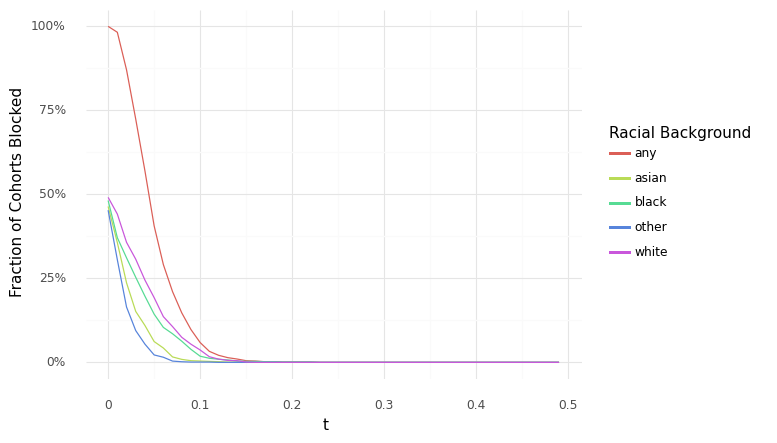

<ggplot: (386434024)>

In [117]:


panels = np.random.choice(all_panels_df.panel_id, size=10)
tt = all_panels_t_closeness(all_panels_df, demo_col, method='t-close', panel_ids = panels)

df = (tt
 .assign(racial_background = lambda x: x.racial_background.map(race_values))
 .groupby(['t', 'racial_background'])
 .agg({'pct_blocked': [np.mean, 
                               lambda x: np.mean(x) + 1.96*np.std(x),
                               lambda x: np.mean(x) - 1.96*np.std(x)]})
 .set_axis(['pct_blocked', 'upper', 'lower'], axis=1, inplace=False)
 .reset_index()
)

(ggplot() +
# geom_ribbon(aes(x='t', ymin='lower', ymax='upper'), alpha=0.02, linetype='dashed', size=0.3) +
 geom_line(aes(x='t', y='pct_blocked', color='racial_background'), data=df) +
# geom_line(aes(x='t', y='pct_blocked'), data=df_mean) +
 labs(y="Fraction of Cohorts Blocked",
    x="t",
    color="Racial Background") +
 theme_minimal() +
 scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l])
# ylim(0, 0.25) +
# xlim(0, 0.5)
)

### 1.3 Plot boxplot for each group using "likelihood"

In [ ]:
panels = np.random.choice(all_panels_df.panel_id, size=10)
tt = all_panels_t_closeness(all_panels_df, demo_col, method='likelihood', panel_ids = panels)

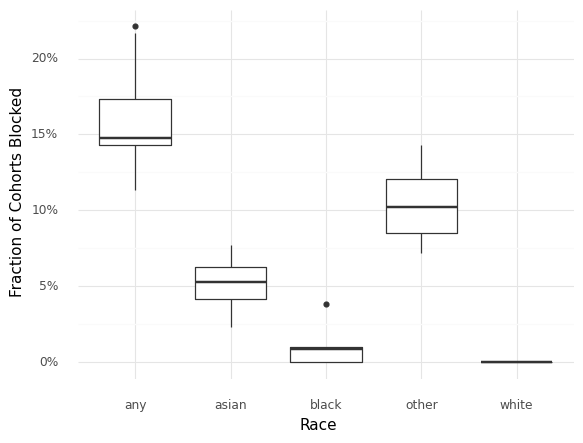

<ggplot: (385918865)>

In [146]:
from plotnine import geom_bar, geom_boxplot


df = (tt
 .assign(racial_background = lambda x: x.racial_background.map(race_values))
      .drop(['t'], axis=1)
      .drop_duplicates()
)

(ggplot() +
# geom_ribbon(aes(x='t', ymin='lower', ymax='upper'), alpha=0.02, linetype='dashed', size=0.3) +
 geom_boxplot(aes(x='racial_background', y='pct_blocked'), data=df) +
# geom_line(aes(x='t', y='pct_blocked'), data=df_mean) +
 labs(y="Fraction of Cohorts Blocked",
    x="Race",
    color="Racial Background") +
 theme_minimal() +
 scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l])
)

---

## Old Code

In [ ]:
def plot_t_closeness(panel_df, demo_col, demo_value_names_dict):
    cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
    demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())
    
    for val in demo_value_names_dict:
        print('%s' % demo_value_names_dict[val])
        cohort_demo_mean = cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.mean()
        print('mean fraction %s across cohorts = %0.2f' % (demo_value_names_dict[val], cohort_demo_mean))
        # Google's sensitivity analysis actually looked at avg for sensitive categories
        # across all users rather than across cohorts
        demo_fraction = demo_fractions[val]
        print('fraction %s across all users in cohorts = %0.2f' % (demo_value_names_dict[val], demo_fraction))

        fig,ax = plt.subplots(1,1,figsize=(6,3), dpi=dpi)
        cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.sort_values(ascending=False).plot.bar(ax=ax, label="")

        ax.hlines(y=demo_fraction, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='-', color='black', label='mean')
        if (demo_fraction - t) > 0:
            ax.hlines(y=demo_fraction-t, xmin=0, xmax=len(ax.get_xticks()), 
                      linestyles='--', color='black', label='mean - t=0.1')
        ax.hlines(y=demo_fraction+t, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='--', color='black', label='mean + t=0.1')
        #ax.legend()
        ax.set_xticks([])
        ax.set_xlabel('cohorts')
        ax.set_ylabel('fraction "%s"' % demo_value_names_dict[val])
        plt.show()
    
    return cohort_demo_portions_df

In [ ]:
demo_col='race'

cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())

In [ ]:

cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())

for val in demo_value_names_dict:
    print('%s' % demo_value_names_dict[val])
    cohort_demo_mean = cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.mean()
    print('mean fraction %s across cohorts = %0.2f' % (demo_value_names_dict[val], cohort_demo_mean))
    # Google's sensitivity analysis actually looked at avg for sensitive categories
    # across all users rather than across cohorts
    demo_fraction = demo_fractions[val]
    print('fraction %s across all users in cohorts = %0.2f' % (demo_value_names_dict[val], demo_fraction))

    fig,ax = plt.subplots(1,1,figsize=(6,3), dpi=dpi)
    cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.sort_values(ascending=False).plot.bar(ax=ax, label="")
    